# Supervised learning of an ANN

In [2]:
import os
import sys
# Add the parent directory (two levels up) to sys.path
sys.path.append(os.path.abspath(os.path.join('..', '..')))
sys.path.append(os.path.abspath(os.path.join('..')))
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from common.tools import stack


<Axes: >

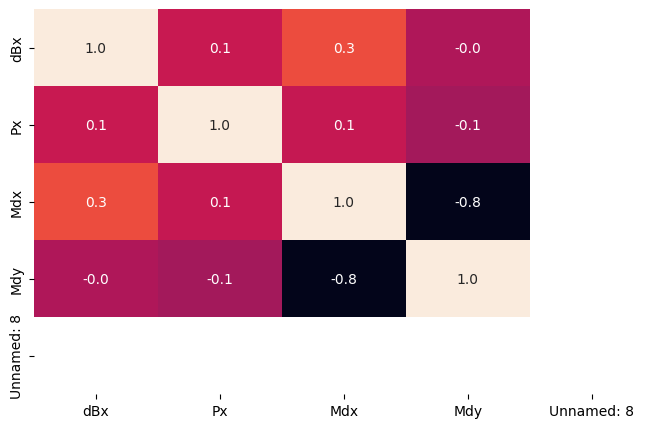

In [3]:
import torch

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = dev
STACK = True

# read data

log_file_path = "../environment/logs/dataset_test/cos_with_jittering_joao.log"

bx, by, px, py, mdx, mdy, score, time, dbx, dby, dataframe  = read_data(log_file_path)
dbx.insert(0, 0)
dby.insert(0, 0)

# dataframe.insert(0,'dBy',dby)
dataframe.insert(0,'dBx',dbx)
dataframe.drop(columns=['Bx', 'By', 'Py', 'Score', 'Time'], inplace=True)
# dataframe.insert(-1,'dBy',dby.append(0))
# Finding correlation between features and plotting them
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5))
sns.heatmap(dataframe.corr( numeric_only=True), cbar = False, annot = True, fmt=".1f")


In [4]:
# data organization
y = np.array(dbx)
mdx = np.array(mdx)
mdy = np.array(mdy)
if STACK:
    Nstack = 10
    stacked_mdx = stack(mdx, Nstack)
    stacked_mdy = stack(mdy, Nstack)

    print("stacked_mdx shape : ",  np.array(stacked_mdy).shape)
    x = np.hstack([np.array(stacked_mdx), np.array(stacked_mdy)])

else :
    x = np.vstack([mdx[1:], mdy[1:]]) # mdx[:] mdx[]

    # print(f"len stacks i  :  {i} :", len(stacks[i]))

# x = np.array(mdx[1:]) # mdx[:] mdx[]


y = torch.tensor([y]).to(torch.float32).to(device)
if STACK:
  x = torch.tensor(x.T).to(torch.float32).to(device)
else:
  x = torch.tensor(x).to(torch.float32).to(device)

print("yshape : ", y.shape)
print("xshape : ", x.shape)
print("min y : ", torch.min(y))

stacked_mdx shape :  (3749, 10)
yshape :  torch.Size([1, 3749])
xshape :  torch.Size([20, 3749])
min y :  tensor(-5.1200, device='cuda:0')


/tmp/ipykernel_13784/3223649708.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  y = torch.tensor([y]).to(torch.float32).to(device)


In [5]:
import torch.nn as nn

class ANN(nn.Module):

    def __init__(self, neurons = [4, 32, 32, 1]):
        super(ANN, self).__init__()

        self.layer = nn.ModuleList([nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))])

    def forward(self, x):

        for i in range(len(self.layer)):
            x = self.layer[i](x)
            if i != len(self.layer) - 1:
                x = nn.LeakyReLU()(x)

        return x
    
if STACK:
    ann_controller = ANN(neurons = [2*Nstack, 128, 1]).to(device)
    ann_controller(torch.tensor(torch.ones(2*Nstack)).to(torch.float32).to(device))
else:
    print("ann without nstack")
    ann_controller = ANN(neurons = [2,  128, 128, 128, 1]).to(device)
    ann_controller(torch.tensor(torch.ones(2)).to(torch.float32).to(device))


/tmp/ipykernel_13784/4017531607.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ann_controller(torch.tensor(torch.ones(2*Nstack)).to(torch.float32).to(device))


In [7]:
# data loader

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

class dataset1D(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
if STACK:
    dataset = dataset1D(x.T, y.T)
else:
    dataset = dataset1D(x.T, y.T)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

train, val = random_split(dataset, [0.8, 0.20])

trainloader = DataLoader(train, batch_size=10, shuffle=True)
valloader = DataLoader(val, batch_size=10, shuffle=True)


In [8]:
# training
import torch


lr = 5e-4
epochs = 1000

opt = torch.optim.Adam(ann_controller.parameters(), lr=lr)


loss_val = []
validation_loss = []

for epoch in range(epochs):

    running_loss = 0.
    last_loss = 0.

    # train one epochs
    for i, data in enumerate(trainloader):
        x, y = data
        vloss = 0
        # free gradient before each bacth
        opt.zero_grad()

        y_pred = ann_controller(x)
        loss = nn.MSELoss()(y_pred, y)
        loss.backward()
        opt.step()
        # opt.zero_grad()

        # Gather data and report
        running_loss += loss.item()
    loss_val.append(running_loss/i)
    for j ,data in enumerate(valloader):
        x, y = data
        y_pred = ann_controller(x)
        loss = nn.MSELoss()(y_pred, y) 
        last_loss += loss.item() 
    validation_loss.append(last_loss/j)
    
    if epoch % 10 == 0:
        print("epochs : {} training loss : {}, Validation loss : {}".format(epoch, loss_val[-1], validation_loss[-1]))
   


epochs : 0 training loss : 6.288956588925327, Validation loss : 5.118001048629348
epochs : 10 training loss : 4.733800113001795, Validation loss : 4.808891703148146
epochs : 20 training loss : 4.502138039738837, Validation loss : 4.520601945148932
epochs : 30 training loss : 4.162044332577632, Validation loss : 4.898735921125154
epochs : 40 training loss : 3.980169329555537, Validation loss : 4.32666386784734
epochs : 50 training loss : 3.8562704151290714, Validation loss : 4.19825254179336
epochs : 60 training loss : 3.7851083237789944, Validation loss : 4.4019682858441325
epochs : 70 training loss : 3.7190822733684525, Validation loss : 4.284147383393468
epochs : 80 training loss : 3.6201945373844544, Validation loss : 5.128415229352745
epochs : 90 training loss : 3.5580308004765206, Validation loss : 4.397645282181534
epochs : 100 training loss : 3.474375501225226, Validation loss : 4.360494946708551
epochs : 110 training loss : 3.4060645733389965, Validation loss : 4.34353085305239

stacked_mdx shape :  (3749, 10)
xshape :  torch.Size([3749, 20])
ypred shape :  torch.Size([3749, 1])
ypred :  tensor([-2.9308, -2.9308, -2.9308,  ...,  0.3830, -0.3529, -2.9990],
       grad_fn=<SelectBackward0>)


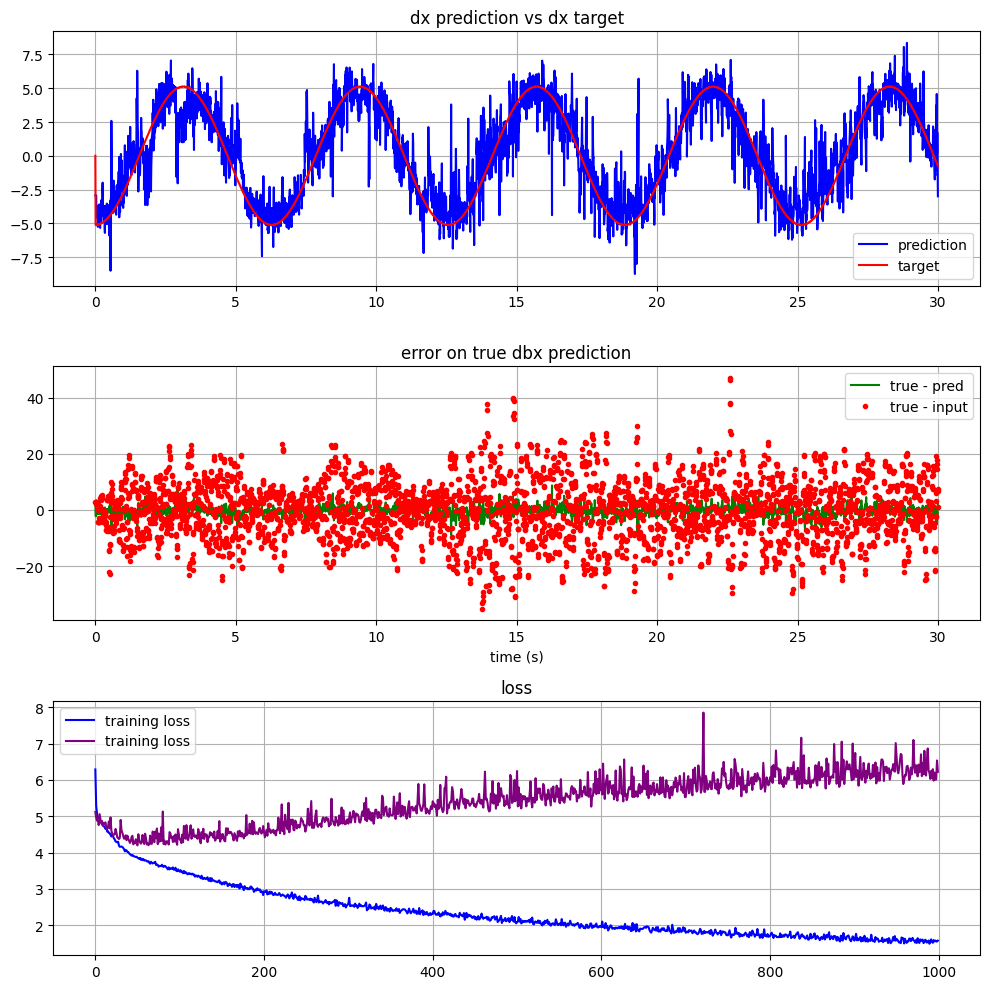

In [10]:
# data organization
y = np.array(dbx)
if STACK:
    Nstack = 10
    stacked_mdx = stack(mdx, Nstack)
    stacked_mdy = stack(mdy, Nstack)

    print("stacked_mdx shape : ",  np.array(stacked_mdy).shape)
    x = np.hstack([np.array(stacked_mdx), np.array(stacked_mdy)])

else :
    x = np.vstack([mdx[1:], mdy[1:]]) # mdx[:] mdx[]

# print(x)
y = torch.tensor([y]).to(torch.float32).to(device)
if STACK:
  x = torch.tensor(x.T).to(torch.float32).to(device)
else:
  x = torch.tensor(x).to(torch.float32).to(device)

# plt.plot(loss_val)

ypred = ann_controller(x.T)
ypred = ypred.to("cpu")
fig, axs = plt.subplots(3,1, figsize=(10, 10))
# axs[0].plot(time[1:], mdx[1:], 'g.', label='input')
axs[0].set_title("dx prediction vs dx target")
axs[0].plot(time[:], ypred[:,0].detach().numpy(), 'b', label='prediction')
axs[0].plot(time[:], y.T[:,0].to("cpu").detach().numpy(), 'r', label='target')
axs[0].legend()

axs[1].set_title("error on true dbx prediction")
axs[1].plot(time[:], dbx[:] - ypred[:,0].detach().numpy(), 'g', label='true - pred')
axs[1].plot(time[:],mdx[:] - ypred[:,0].detach().numpy(), 'r.', label='true - input')
axs[1].set_xlabel("time (s)")
axs[1].legend()

axs[2].set_title("loss")
axs[2].plot(loss_val, 'b', label='training loss')
axs[2].plot(validation_loss, 'purple', label='training loss')

plt.legend()

for ax in axs:
    ax.grid(True)

    

print("xshape : ", x.T.shape)
print("ypred shape : ", ypred.shape)
print("ypred : ", ypred[:,0])
plt.tight_layout()


# 2. Validation

In [11]:
mdx.shape

if STACK:

    stacked_mdx = stack(mdx, Nstack)
    stacked_mdy = stack(mdy, Nstack)

    print("stacked_mdx shape : ",  np.array(stacked_mdy).shape)
    x = np.hstack([np.array(stacked_mdx), np.array(stacked_mdy)])
else :
    x = np.vstack([mdx[1:], mdy[1:]]).T # mdx[:] mdx[]

est_player_x_poss = []
est_dxs = []

player_p = 0
# env running
for index , t in enumerate(time[1:]):

    # get observation 
    mouse_mvt = x[index, :]
    mouse_dx = mdx[index]
    mouse_dy = mdy[index]
    ball_pos_x = bx[index]
    player_pos_x = px[index]


    # get action
    est = ann_controller(torch.tensor(mouse_mvt).to(torch.float32).to(device))

    est_dx = est[0]
    est_dxs.append(est_dx.to("cpu").detach().numpy())
    # est_dy = est[1]

    # compute score 
    # compute t+1 player position with est_dx, est_dy
    # est_player_pos_x = player_pos_x + est_dx
    player_p +=  est_dx
    est_player_x_poss.append(player_p.item())

    # print("player_p  : ", player_p)
    # print("est_player_x_poss  : ", est_player_x_poss[-1])
    # est_player_x_poss += [est_player_pos_x.to("cpu").detach().numpy()]
    # est_player_x_poss += [player_p.to("cpu").detach().numpy()]
    

    ball_pos_x = bx[index+1]


    score = 1/(ball_pos_x - player_p)**2

    # print("score : ", score)
    

stacked_mdx shape :  (3749, 10)


In [83]:
for i, data in enumerate(trainloader):
        x, y = data
        y_pred = ann_controller(x)
        mse = (y - y_pred)**2
        print("y_pred : {}, y target {}, mse {}".format(ypred[1], y[1], mse))

        # opt.zero_grad()

y_pred : tensor([0.3358], grad_fn=<SelectBackward0>), y target tensor([0.9400], device='cuda:0'), mse tensor([[0.0417],
        [0.3706],
        [0.9175],
        [0.1716],
        [0.0830],
        [0.0444],
        [0.0721],
        [0.3297],
        [0.7003],
        [6.7025]], device='cuda:0', grad_fn=<PowBackward0>)
y_pred : tensor([0.3358], grad_fn=<SelectBackward0>), y target tensor([-5.0400], device='cuda:0'), mse tensor([[1.8009],
        [0.0462],
        [0.2427],
        [0.1323],
        [0.5186],
        [4.9542],
        [1.4441],
        [0.0799],
        [1.0004],
        [8.5482]], device='cuda:0', grad_fn=<PowBackward0>)
y_pred : tensor([0.3358], grad_fn=<SelectBackward0>), y target tensor([-0.0200], device='cuda:0'), mse tensor([[4.2408e-02],
        [1.2659e-01],
        [2.2650e-04],
        [4.4544e-01],
        [9.0082e+00],
        [1.6467e-01],
        [2.4517e+00],
        [2.4406e-01],
        [2.9616e-01],
        [1.9379e+00]], device='cuda:0', grad_fn=<P

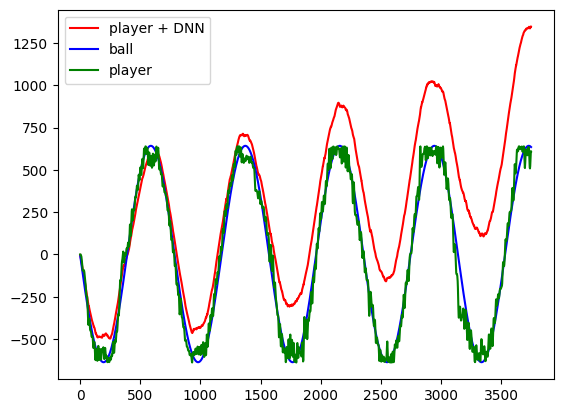

In [12]:

plt.plot(est_player_x_poss, 'r', label='player + DNN')
plt.plot(bx[1:], 'b', label='ball')
plt.plot(px, 'g', label='player')

plt.legend()

In [ ]:
score_ia = np.sum((np.array(dbx[1:]) - est_dxs)**2)/len(mdx)
score_init = np.sum((mdx[1:] - np.array(dbx[1:]))**2)/len(mdx)

print("erreur ia : ", score_ia)
print("erreur init : ", score_init)


score ia :  0.9566354026761348
score init :  4.061812776740465


# 3. Write data in file

In [87]:
# write_to_file("linear_input.in", est_dxs, 0*np.array(est_dxs))